In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from pathlib import Path

In [2]:
def get_df_from_path(hdf5filePath):
    h = h5py.File(hdf5filePath, 'r+')
    history = h['history']
    colnames = history.attrs['column_names']
    assert len(history) == len(colnames)
    nbcols = len(colnames)
    _ = dict()
    for i, colname in zip(range(nbcols), colnames):
        _[colname] = history[i]
    return pd.DataFrame(_)
def get_info_from_path(hdf5filePath):
    #'HDF5Files/toyRates_logM-0.1_X0.6.hdf5' is a filepath, get logM and X from it
    logM = float(hdf5filePath.split('logM')[1].split('_')[0])
    X = float(hdf5filePath.split('X')[1].split('_')[0])
    return logM, X
def get_µ_from_X(X): return 4 / ( 3 + 5*X )
#benadering: M(H1) is niet helemaal 1, en dan nog isotopenbenadering en Z = A/2 ofzo enzo

In [3]:
p = Path('.')
_ = list(p.glob('Histories/*.hdf5'))
paths = [str(hdf5file) for hdf5file in _]
data = {path : get_df_from_path(path) for path in paths}
print(f" {len(data)} history files found")
print(data[paths[0]].columns)

 112 history files found
Index(['star_age', 'dt', 'model_number', 'star_mass', 'R_surf', 'L_surf',
       'T_surf', 'P_surf', 'ρ_surf', 'X_surf', 'Y_surf', 'T_center',
       'P_center', 'ρ_center', 'X_center', 'Y_center'],
      dtype='object')


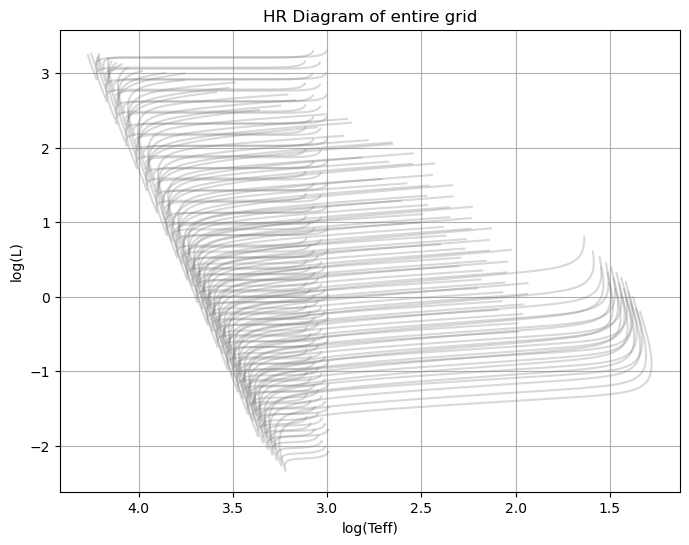

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for path in paths:
    logM, X = get_info_from_path(path)
    M = round(10**logM,1)
    history = data[path]
    ax.plot(np.log10(history.T_surf), np.log10(history.L_surf), label=f'M={M}, X={X}',color='gray',alpha=0.3)
    #plot mass
    #ax.plot(data[path].model_number,data[path].star_mass)
ax.set_xlabel('log(Teff)')
ax.set_ylabel('log(L)')
ax.set_title('HR Diagram of entire grid')
ax.invert_xaxis()
ax.grid()
#ax.set_ylim(0.8,1)

In [6]:
logMRange = np.linspace(-1, 1, 21) 
#make a color dictionary
colors = plt.cm.viridis(np.linspace(0, 1, len(logMRange)))
colors = {np.round(logM,1) : color for logM, color in zip(logMRange, colors)}
shapes = ['o','s','*','X','D','o','s','*','X','D','o','s','*','X','D','o','s','*','X','D','o']
shapes = {np.round(logM,1) : shape for logM, shape in zip(logMRange, shapes)}

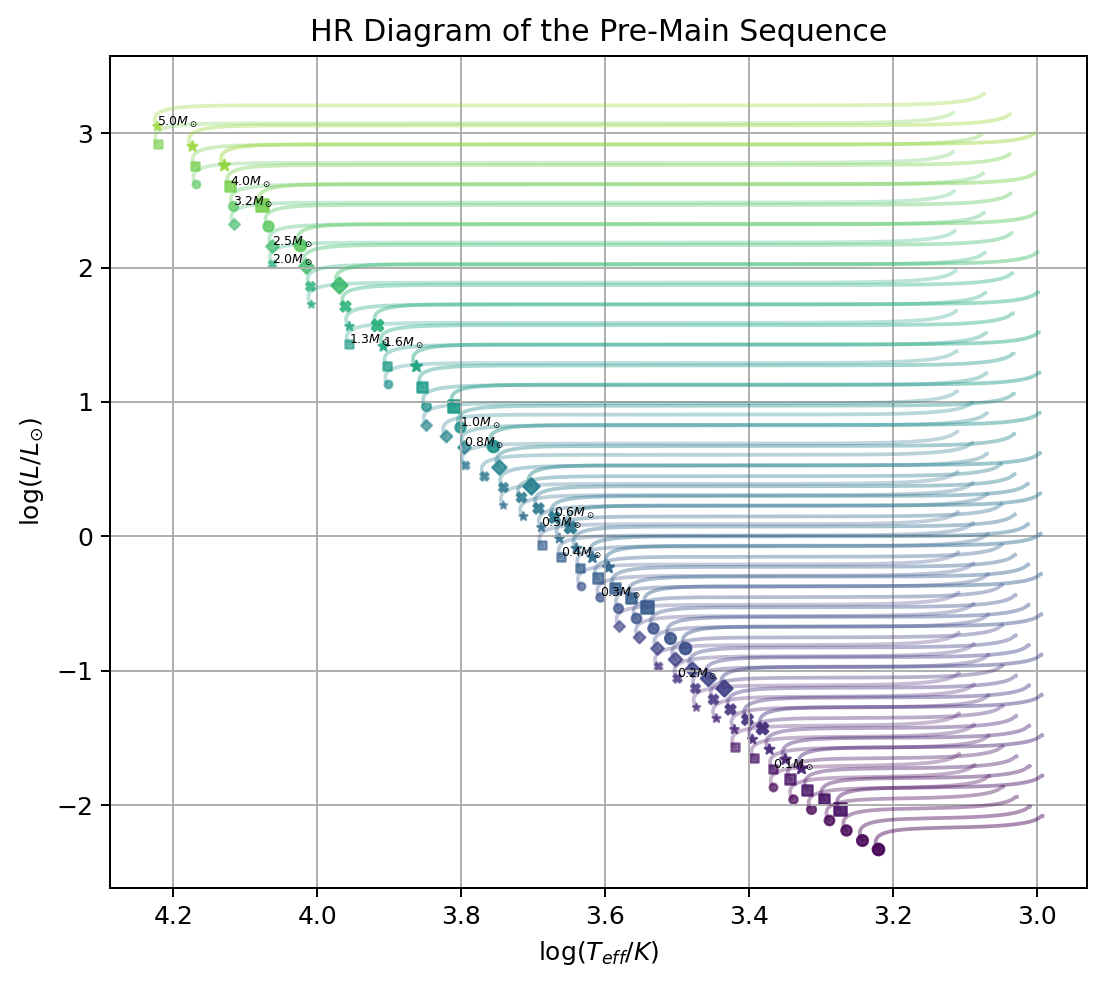

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6),dpi=180)
already_done = []
for path in paths:
    logM, X = get_info_from_path(path)
    M = round(10**logM,1)
    history = data[path]
    #if X not in [0.7] and logM not in [0.0]: continue
    try:
        ZAMS_index = np.where(history.X_center < 0.99 * history.X_center[0])[0][0]
        ax.plot(np.log10(history.T_surf[0:ZAMS_index]), np.log10(history.L_surf[0:ZAMS_index]), label=f'M={M}, X={X}',color=colors[logM],alpha=X/2)
        ax.scatter(np.log10(history.T_surf[ZAMS_index]), np.log10(history.L_surf[ZAMS_index]), s=(5*X)**2,color=colors[logM], marker=shapes[logM],alpha=X )
        if M not in already_done:
            ax.text(np.log10(history.T_surf[ZAMS_index]), np.log10(history.L_surf[ZAMS_index]), f'${M} M_\odot$',fontsize=5)
            already_done.append(M)
    except:
        continue
ax.set_xlabel('$\log(T_{eff} / K)$')
ax.set_ylabel('$\log( L / L_{\odot} )$')
ax.set_title('HR Diagram of the Pre-Main Sequence')
ax.grid()
ax.invert_xaxis()

In [247]:
dict_logL_PMS = dict()
dict_ZAMS_index = dict()
dict_PMS_index = dict()
dict_logL_ZAMS = dict()
Temp_reference = 10**3.2
for path in paths:
    history = data[path]
    logM, X = get_info_from_path(path)
    M = round(10**logM,1)       
    if M > 0.3: continue

    try:
        #ZAMS
        ZAMS_index = np.where(history.X_center < 0.999 * history.X_center[0])[0][0]
        dict_ZAMS_index[path] = ZAMS_index
        dict_logL_ZAMS[path] = np.log10(history.L_surf[ZAMS_index])

        #PMS
        settledOnPMS_index = np.argmin(history.T_surf[0:ZAMS_index] - Temp_reference)
        dict_PMS_index[path] = settledOnPMS_index
        dict_logL_PMS[path] = np.log10(history.L_surf[settledOnPMS_index])
    except:
        print(f"Failed for X = {X}, logM = {logM}")
all_logL_PMS = np.array(list(dict_logL_PMS.values()))
all_logL_ZAMS = np.array(list(dict_logL_ZAMS.values()))

Text(0.5, 1.0, 'logL on PMS (visualisation of the grid)')

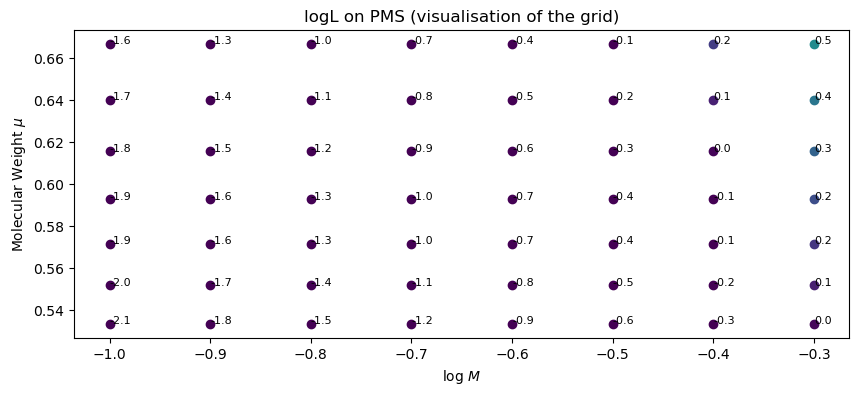

In [238]:
fig, ax = plt.subplots(1,1,figsize=(10,4),dpi=100)
cmap = plt.cm.viridis
norm = plt.Normalize(all_logL_PMS.min(), all_logL_PMS.max())
for path, logL in dict_logL_PMS.items():
    logM, X = get_info_from_path(path)
    µ = get_µ_from_X(X)
    M = 10**logM
    #now plot logM, µ, L with L on colorscale
    ax.scatter(logM, µ, color=cmap(logL))
    ax.text(logM, µ, f'{np.round(logL,1)}', fontsize=8)
ax.set_xlabel('log $M$')
ax.set_ylabel('Molecular Weight $\mu$')
ax.set_title('logL on PMS (visualisation of the grid)')

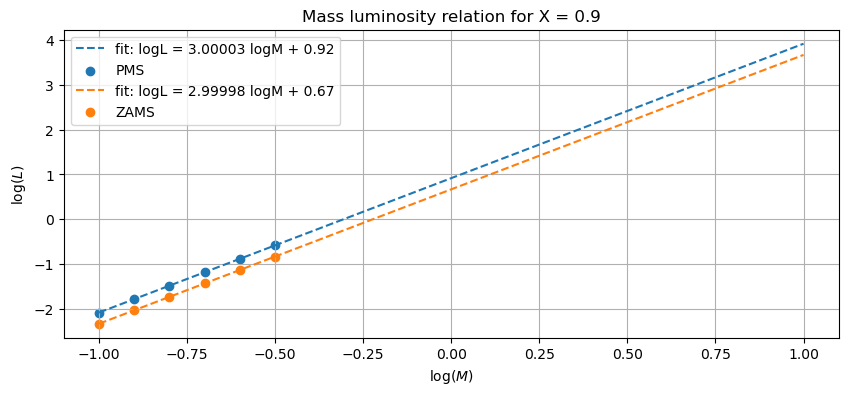

In [251]:
def modelRelation(logM, a, b):
    logL =  a*logM + b
    return logL

from scipy.optimize import curve_fit
#select all logM, logL with X = 0.7
X = 0.9
selected_logL_PMS = np.array([logL for path, logL in dict_logL_PMS.items() if get_info_from_path(path)[1] == X])
selected_logL_ZAMS = np.array([logL for path, logL in dict_logL_ZAMS.items() if get_info_from_path(path)[1] == X])
selected_logM = np.array([get_info_from_path(path)[0] for path, logL in dict_logL_PMS.items() if get_info_from_path(path)[1] == X])

#fit a line to the data
params_PMS, pcov_PMS = curve_fit(modelRelation, selected_logM, selected_logL_PMS)
params_ZAMS, pcov_ZAMS = curve_fit(modelRelation, selected_logM, selected_logL_ZAMS)
#plot
fig, ax = plt.subplots(1,1,figsize=(10,4),dpi=100)
logMRange = np.linspace(-1, 1, 200)
ax.plot(logMRange, modelRelation(logMRange, *params_PMS), label=f'fit: logL = {np.round(params_PMS[0],5)} logM + {np.round(params_PMS[1],2)}',ls='--')
ax.scatter(selected_logM, selected_logL_PMS, label='PMS')

ax.plot(logMRange, modelRelation(logMRange, *params_ZAMS), label=f'fit: logL = {np.round(params_ZAMS[0],5)} logM + {np.round(params_ZAMS[1],2)}',ls='--')
ax.scatter(selected_logM, selected_logL_ZAMS, label='ZAMS')

ax.set_xlabel('$\log(M)$')
ax.set_ylabel('$\log(L)$')
ax.set_title(f'Mass luminosity relation for X = {X}')
ax.legend()
ax.grid()


In [249]:
pcov_ZAMS

array([[1.96236117e-08, 1.47177089e-08],
       [1.47177089e-08, 1.16106371e-08]])

No using the model $L = f(X(\mu)) M^3$. And $L \propto \frac{1}{\kappa} \mu^4 M^3$, hence $f \propto \mu^4 / \kappa$.

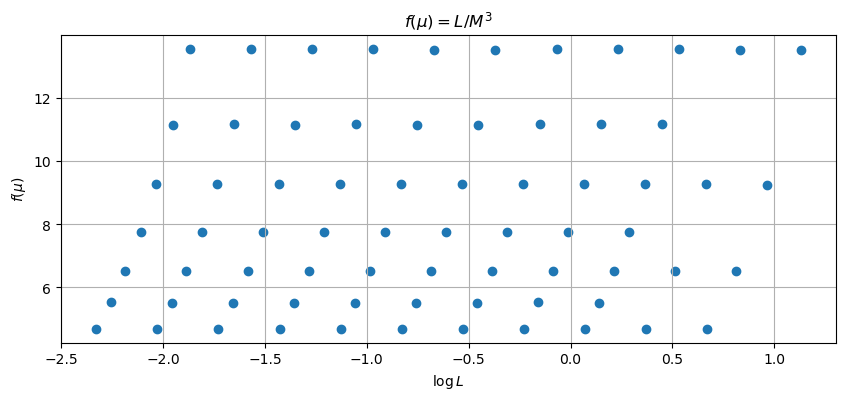

In [233]:
fig, ax = plt.subplots(1,1,figsize=(10,4),dpi=100)
µs = []
Xs = []
fs = []
for path, logL in dict_logL_ZAMS.items():
    logM, X = get_info_from_path(path)
    µ = get_µ_from_X(X)
    M = 10**logM
    f = 10**logL / M**3
    µs.append(µ)
    Xs.append(X)
    fs.append(f)

#ax.scatter(µs, fs, label = 'ZAMS')
ax.scatter(dict_logL_ZAMS.values(), fs)
µs = []
Xs = []
fs = []
for path, logL in dict_logL_PMS.items():
    logM, X = get_info_from_path(path)
    µ = get_µ_from_X(X)
    M = 10**logM
    f = 10**logL / M**3
    µs.append(µ)
    Xs.append(X)
    fs.append(f)
#ax.scatter(µs, fs, label = 'PMS')
ax.set_xlabel('$\log L$')
ax.set_ylabel('$f(\mu)$')
ax.grid()
ax.title.set_text('$f(µ) = L / M^3 $')

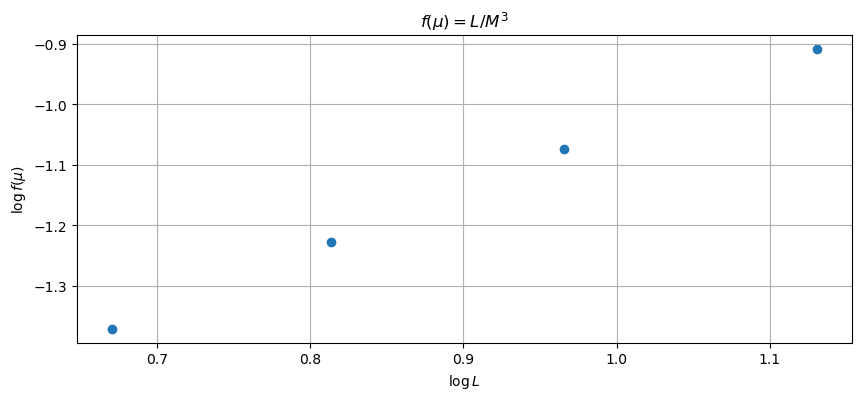

In [234]:
fig, ax = plt.subplots(1,1,figsize=(10,4),dpi=100)
µs = []
Xs = []
fs = []
logLs = []
for path, logL in dict_logL_ZAMS.items():
    logM, X = get_info_from_path(path)
    if logM != 0:
        continue
    logLs.append(logL)
    µ = get_µ_from_X(X)
    M = 10**logM
    f = µ**4 / (1+X)

    µs.append(µ)
    Xs.append(X)
    fs.append(f)

#ax.scatter(µs, fs, label = 'ZAMS')
ax.scatter(logLs, np.log10(fs))
#ax.scatter(µs, fs, label = 'PMS')
ax.set_xlabel('$\log L$')
ax.set_ylabel('$\log f(\mu)$')
ax.grid()
ax.title.set_text('$f(µ) = L / M^3 $')